Первый рентгеновский снимок появился в 1895 году и с тех времен он стал неотъемлемый частью клинической помощи. К 2021 году объём достиг более трех с половиной миллиардов терабайт медицинский изображений в одной только США. Всё это открывает огромные возможности для анализа изображений. Например: прогнозирование патологии с помощью нейронных сетей, измерение формы и размеров органов, создание 3D реконструкций.


## Данные


В этой задачи мы разработаем модель, позволяющую классифицировать (и, если таковая имеется, сегментировать) пневмоторакс по набору рентгенографических изображений грудной клетки. В случае успеха мы могли бы помочь в раннем распознавании пневмоторакса и спасти жизни.

DICOM (Digital Imaging and Communications in Medicine) — медицинский отраслевой стандарт создания, хранения, передачи и визуализации цифровых медицинских изображений и документов обследованных пациентов. Стандарт DICOM разработан Национальной ассоциацией производителей электронного оборудования (National Electrical Manufacturers Association).

In [34]:
!pip install pydicom
!pip install nibabel

In [35]:
import pydicom # библиотека для работы с DICOM файлами
import nibabel # библиотека для работы с NIfTI-1 Data Format
from matplotlib import cm # цветовые схемы для визуализации
from matplotlib import pyplot as plt # библиотека для визуализации 

# Импортируем нужные библиотеки
import numpy as np
from skimage.exposure import equalize_hist
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.segmentation import felzenszwalb
from skimage.transform import rescale

In [36]:
example = '/content/drive/MyDrive/Снимки/stage_2_images/ID_01fe90211.dcm'
imagedata= pydicom.dcmread(example)

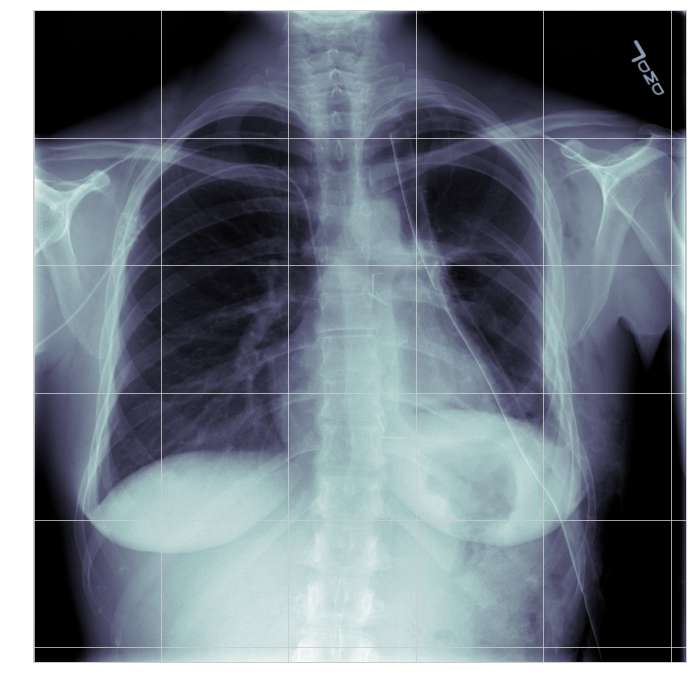

In [37]:
plt.figure(figsize=(12, 12))
plt.imshow(imagedata.pixel_array, cmap=plt.cm.bone)
plt.show()

In [38]:
filepath = '/content/drive/MyDrive/Снимки/St2/volume-45.nii'
imagedata = nibabel.load(filepath)
array = imagedata.get_fdata()

In [39]:
array   = np.rot90(np.array(array))
print(array.shape)

(512, 512, 74)


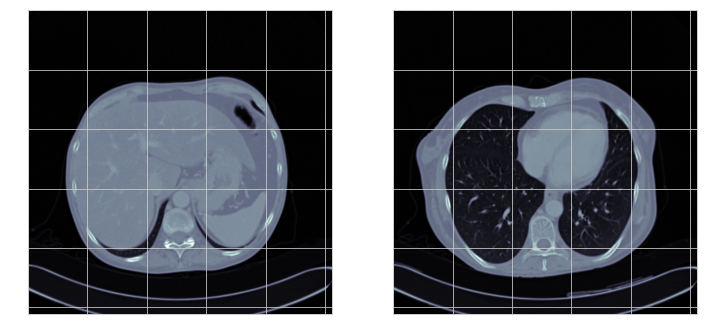

In [40]:
f = plt.figure(figsize=(12,12))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(array[...,50].astype(np.float32), cmap=plt.cm.bone)
ax2.imshow(array[...,73].astype(np.float32), cmap=plt.cm.bone)

In [41]:
# Давайте попробуем исследовать наши метаданные. Начнём с того, что мы уже знаем, с чтениям файла
example = '/content/drive/MyDrive/Снимки/stage_2_images/ID_01fe90211.dcm'
imagedata= pydicom.dcmread(example)

In [42]:
print("ID:", imagedata.PatientID)
print("Возраст:", imagedata.PatientAge)
print("Пол:", imagedata.PatientSex)
print("Модальность:", imagedata.Modality)
print("Часть тела:", imagedata.BodyPartExamined)
print("Рентгенологический вид изображения относительно ориентации объекта:", imagedata.ViewPosition)

ID: 
Возраст: 26
Пол: F
Модальность: CR
Часть тела: CHEST
Рентгенологический вид изображения относительно ориентации объекта: PA


Думаю с ID, возрастом и полом (F-Female, M-Male) всё понятно. Разберемся с модальностью. Основные типы (модальности) поддерживаемых стандартом DICOM медицинских изображений представлены ниже:

* CR — Компьютерная рентгенография (Computed Radiography);
* CT — Компьютерная томография (Computed Tomography);
* DX — Цифровая рентгенография (Digital Radiography);
* MG — Маммография (Mammography).

Часть тела: CHEST - грудная клетка. 

Ориентации объекта изображения.
* PA - передняя, 
* AP - задняя.

In [43]:
# Еще отдельно мы можем проверить есть ли в DICOM файле изображение и её размер.
if 'PixelData' in imagedata:
    rows = int(imagedata.Rows)
    cols = int(imagedata.Columns)
    print("Размер изображения : {rows:d} x {cols:d}, {size:d} байт".format(
        rows=rows, cols=cols, size=len(imagedata.PixelData)))

Размер изображения : 1024 x 1024, 158236 байт


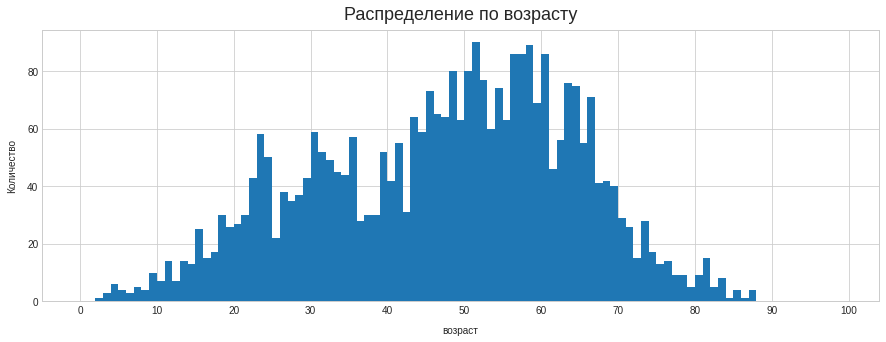

In [11]:
# А теперь давайте сделаем небольшой обзор данных. Например, посмотрим какое распределения возраста и пола в нашем датасете.

from glob import glob
import pandas as pd
import seaborn as sns

datalist = sorted(glob("/content/drive/MyDrive/Снимки/stage_2_images/*.dcm")) # создадим лист содержащий пути ко всем файлам

# Для удобства анализа создадим датафрейм с метаданными
patients = []

for t in datalist:
    data = pydicom.dcmread(t)
    patient = {}
    patient["UID"] = data.SOPInstanceUID
    patient["Age"] = data.PatientAge
    patient["Sex"] = data.PatientSex
    patient["Modality"] = data.Modality
    patient["BodyPart"] = data.BodyPartExamined
    patient["ViewPosition"] = data.ViewPosition
    patients.append(patient)

df_patients = pd.DataFrame(patients, columns=["UID", "Age", "Sex", "Modality", "BodyPart", "ViewPosition"])
df_patients["Age"] = pd.to_numeric(df_patients["Age"])

# Построим гистограмму
sorted_ages = np.sort(df_patients["Age"].values)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 5))
plt.hist(sorted_ages[:-2], bins=[i for i in range(100)])
plt.title("Распределение по возрасту", fontsize=18, pad=10)
plt.xlabel("возраст", labelpad=10)
plt.xticks([i*10 for i in range(11)])
plt.ylabel("Количество", labelpad=10)
plt.show()

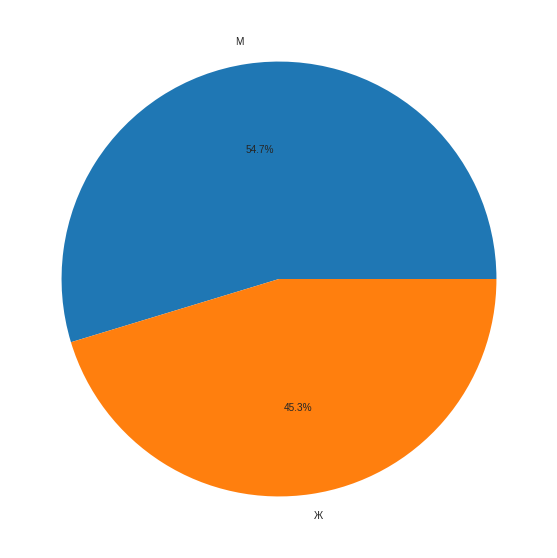

In [12]:
plt.figure(figsize=(10, 10))
plt.pie([df_patients[df_patients["Sex"] == "M"].shape[0], df_patients[df_patients["Sex"] == "F"].shape[0]], labels=["М", "Ж"], autopct='%1.1f%%')
plt.show()

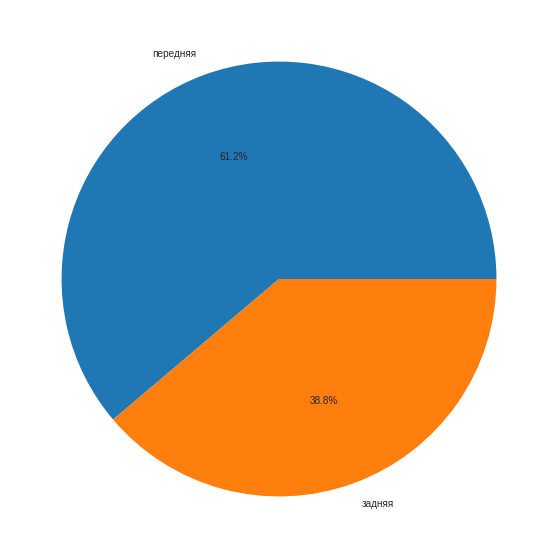

In [13]:
plt.figure(figsize=(10, 10))
plt.pie([df_patients[df_patients["ViewPosition"] == "PA"].shape[0], df_patients[df_patients["ViewPosition"] == "AP"].shape[0]], labels=["передняя", "задняя"], autopct='%1.1f%%')
plt.show()

Часто в работе нужно будет конвертировать DICOM формат в обычные изображения, например PNG, а так же изменять размер исходного изображения.

In [14]:
# Такой вариант работает, но не учитывает метаданные, которые относятся к изображению
from skimage.transform import resize
import cv2

example = '/content/drive/MyDrive/Снимки/stage_2_images/ID_01fe90211.dcm'
imagedata= pydicom.dcmread(example)

img =imagedata.pixel_array
name = example.split('/')[-1][:-4]
img = resize(img,(512,512))
cv2.imwrite('{}.png'.format(name), img * 255)

True

In [15]:
print(imagedata.BitsAllocated)
print(imagedata.PhotometricInterpretation)

8
MONOCHROME2


При работе с изображениями пациентов, часто необходимо анонимизировать файлы. Например, при передачи снимков на разметку врачам.

In [16]:
example = '/content/drive/MyDrive/Снимки/stage_2_images/ID_01fe90211.dcm'
imagedata= pydicom.dcmread(example)
imagedata.remove_private_tags()

In [17]:
# Можно удалить метатег.
if 'PatientSex' in imagedata:
    delattr(imagedata, 'PatientSex')

In [18]:
# Можно изменить значение метатега.
#tag = 'PatientAge'
#if tag in imagedata:
#    imagedata.data_element(tag).value = '1111'

In [19]:
output_filename = 'newdicom.dcm'
imagedata.save_as(output_filename)

Windowing - это процесс, с помощью которого изменяется внешний вид изображения, чтобы выделить определенные структуры. Это достигается путём отображения уровней серого, растяжением контраста, модификации гистограммы или усилением контраста. Яркость изображения регулируется уровнем окна (window level). Контрастность регулируется шириной окна (window width).

In [20]:
# будет использовать уже знакомый нам снимок КТ.
filepath = '/content/drive/MyDrive/Снимки/St2/volume-44.nii'
imagedata = nibabel.load(filepath)
array   = imagedata.get_fdata()
array   = np.rot90(np.array(array))

In [21]:
# Еще дополнительно нам нужна функция windowed , на вход принимает изображение, ширину и уровень окна.
def windowed(px, w, l):
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

In [22]:
print(array[...,50].astype(np.float32))
print()
print(windowed(array[...,50].astype(np.float32), 150, 30))

[[-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 ...
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


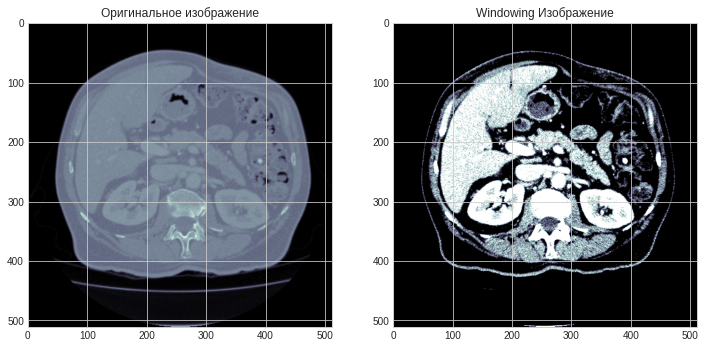

In [23]:
# Давайте визуализируем изображение до преобразования и после.
f = plt.figure(figsize=(12,12))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(array[...,50].astype(np.float32), cmap=plt.cm.bone)
ax.title.set_text('Оригинальное изображение')
ax2.imshow(windowed(array[...,50].astype(np.float32), 150,30), cmap=plt.cm.bone)
ax2.title.set_text('Windowing Изображение')

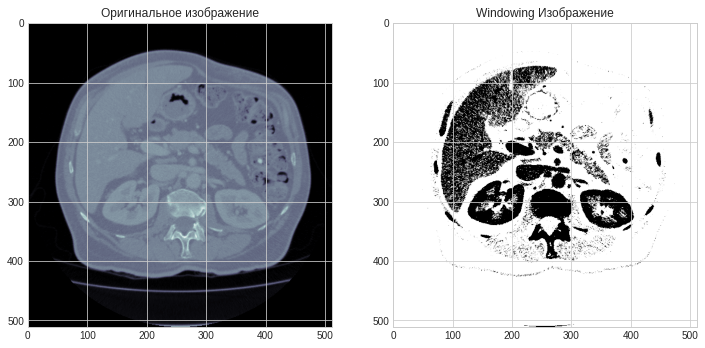

In [24]:
def rainbow_bsb_window(img):
    brain_img = windowed(img, 40, 80)
    subdural_img = windowed(img, 80, 200)
    bone_img = windowed(img, 600, 2000)
    combo = (brain_img*0.3 + subdural_img*0.5 + bone_img*0.2)
    return combo

f = plt.figure(figsize=(12,12))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(array[...,50].astype(np.float32), cmap=plt.cm.bone)
ax.title.set_text('Оригинальное изображение')
ax2.imshow(rainbow_bsb_window(array[...,50].astype(np.float32)))
ax2.title.set_text('Windowing Изображение')

Сегментация изображения — это разделение изображения на несколько сегментов (множество пикселей). Сегментация изображений обычно используется для того, чтобы выделить объекты и границы на изображениях. Более точно, сегментация изображений — это процесс присвоения таких меток каждому пикселю изображения, что пиксели с одинаковыми метками имеют общие визуальные характеристики.

Рассмотрим алгоритм сегментации на основе графов Felsenszwalb из библиотеки skimage. Алгоритм производит сегментацию многоканального (например, RGB) изображения с использованием быстрой кластеризации на основе минимального связующего дерева на сетке изображения. Параметр scale задает уровень наблюдения. Чем выше scale, тем меньше сегментов и они большего размера. sigma - это диаметр гауссова ядра, используемого для сглаживания изображения перед сегментацией.

In [25]:
example = '/content/drive/MyDrive/Снимки/stage_2_images/ID_01fe90211.dcm'
imagedata= pydicom.dcmread(example)

In [26]:
# Занулим значения больше 65
im_thres = imagedata.pixel_array.copy()
im_thres[im_thres > 65] = 0

In [27]:
# Масштабируем и фильтруем и нормализовываем картинку
im_small = rescale(im_thres, 0.5)
im_small_filt = median(im_small, disk(50))   
im_small_filt = equalize_hist(im_small_filt)

/usr/local/lib/python3.7/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


In [28]:
# Запускаем алгоритм
segments = felzenszwalb(im_small_filt, scale=0.5)

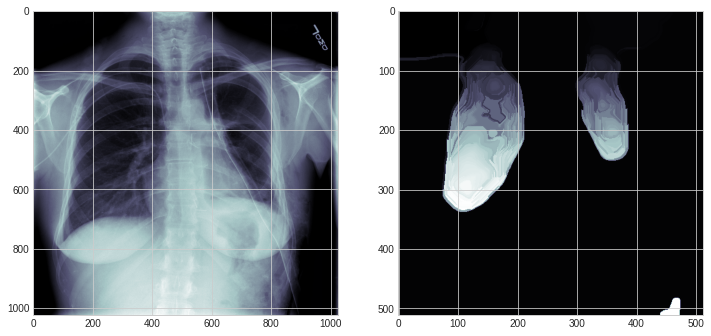

In [29]:
# Визуализируем и посмотрим, что получилось
f = plt.figure(figsize=(12,12))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(imagedata.pixel_array, cmap=plt.cm.bone)
ax2.imshow(segments, cmap=plt.cm.bone)

Гораздо лучше с задачей сегментации изображений справляются нейронные сети. Рассмотрим несколько уже готовых библиотек, которые в основе имеют уже обученные модели и решают задачу сегментации медицинских изображений.

In [30]:
!pip install lungs-segmentation

     |████████████████████████████████| 28.2MB 92kB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 798kB 31.4MB/s 
     |████████████████████████████████| 13.1MB 232kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 12.8MB 254kB/s 
     |████████████████████████████████| 20.0MB 1.8MB/s 
     |████████████████████████████████| 952kB 26.2MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.17.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: opencv-python 4.1.2.30
    Uni

In [ ]:
# Библиотека работает с PNG изображениями, поэтому сначала сконвертируем изображение уже знакомым нам способом.
from skimage.transform import resize
import cv2

example = '/content/drive/MyDrive/Снимки/stage_2_images/ID_01fe90211.dcm'
imagedata= pydicom.dcmread(example)

img =imagedata.pixel_array
name = example.split('/')[-1][:-4]
img = resize(img,(512,512))
cv2.imwrite('{}.png'.format(name), img * 255)

In [ ]:
!pip uninstall -y mxnet && pip install mxnet-cu90==1.1.0

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Downloading: "https://github.com/alimbekovKZ/lungs_segmentation/releases/download/1.0.0/resnet34.pth" to /root/.cache/torch/hub/checkpoints/resnet34.pth


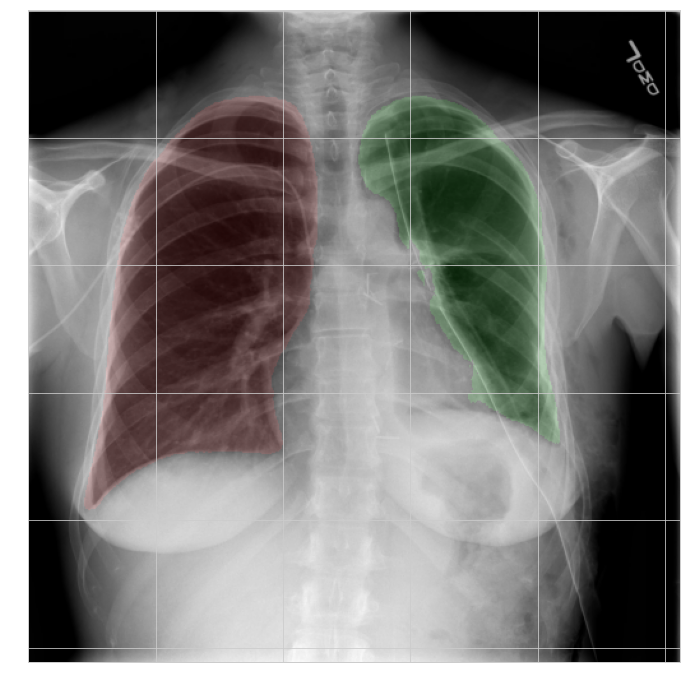

In [33]:
# После чего импортируем lungs-segmentation и запускаем обработку моделью
from lungs_segmentation.pre_trained_models import create_model
import lungs_segmentation.inference as inference
import torch

model = create_model("resnet34")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
image, mask = inference.inference(model,'ID_01fe90211.png', 0.2)
plt.imshow(inference.img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

Результат получился просто отличный!